265665


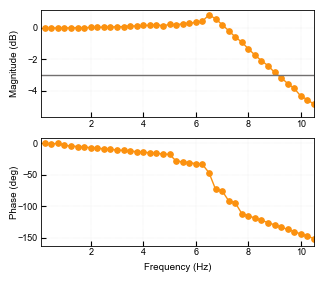

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

custom_colors = {
    "orange" : "#fb910f",
    "muted_red" : "#f16767",
    "light_pink": "#d8a3a1",
    "deep_red": "#953635",
    "blush": "#efc9c4",
    "darker_red": "#c64f4a",
    "light_gray": "#d3d3d3",
    "medium_gray": "#5e5e5e"
}


def generate_test_frequencies():
    """Generate logarithmically spaced frequencies with dense sampling around resonance"""
    # Base parameters
    low_freq = 0.1
    high_freq = 12
    resonance = (7, 11)
    
    # Create logarithmic spacing outside resonance region
    low_range = np.geomspace(low_freq, resonance[0], 10, endpoint=False)
    high_range = np.geomspace(resonance[1], high_freq, 4)
    
    # Linear spacing in resonance region
    res_range = np.linspace(resonance[0], resonance[1], 17)
    
    # Combine and ensure uniqueness
    return np.unique(np.concatenate([low_range, res_range, high_range]))

test_freq = np.linspace(0.25,11,44)
amplitude = 10
duration = 5
bias = 20
init_time = 5
sampling_freq = 200
csv_file = r"exo_data\BandwidthAnalysis.csv"


def segment_data(df):
    segmented_data = {}
    print(df.size)
    for i,freq in enumerate(test_freq):
        start_time = init_time + 2*i*duration
        end_time = start_time + duration
        time_mask = (df["loop_time"] >= start_time) & (df["loop_time"] <= end_time)
        segment = df[time_mask].copy()
        segmented_data[freq] = segment
        # print(segmented_data[freq].shape)
    return segmented_data

def get_bode_data(input_d, output_d, testing_freq):
    input_d = np.array(input_d) - bias
    output_d = np.array(output_d) - bias
    if len(input_d) == 0 or len(output_d) == 0:
        print(f"Empty input detected for {testing_freq}Hz test")
        return (np.nan, np.nan)
    
    delta_samples = np.argmax(np.correlate(input_d, output_d, mode="full")) - (len(input_d) - 1)
    phase_shift = 2*180*testing_freq*(delta_samples / sampling_freq) 
    
    input_mag = np.sqrt(2) * np.std(input_d)
    output_mag = np.sqrt(2) * np.std(output_d)

    mag_dB = 20*np.log10(output_mag/input_mag)
    return (mag_dB, phase_shift)

def draw_bode(bode_data):
    # Sort frequencies in ascending order
    freqs = sorted(bode_data.keys())
    mags = [bode_data[f][0] for f in freqs]
    phases = [bode_data[f][1] for f in freqs]
    
    # ===== PLOT SETUP =====

    plt.style.use('seaborn-v0_8-paper')

    plt.rcParams.update({
        'font.family': 'Arial',
        'font.size': 6,
        'axes.labelsize': 7,
        'xtick.labelsize': 6.5,
        'ytick.labelsize': 6.5,
        'legend.fontsize': 7,
        'axes.linewidth': 0.6,
        'grid.linewidth': 0.4,
        'lines.linewidth': 1,
        'xtick.major.pad': 2,
        'ytick.major.pad': 2,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })

    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.2, 2.8))  # IEEE 2-column format: ~3.5" wide

    # ---- Magnitude Plot ----
    ax1.plot(freqs, mags,
            color=custom_colors['orange'],
            linestyle='-',
            marker='o',                      # Changed to cross marker
            markersize=4,
            markeredgewidth=0.8)
    ax1.axhline(y=-3, color="#727070")
    ax1.set_ylabel('Magnitude (dB)')
    ax1.set_xlim([0.1, 10.5])
    ax1.grid(True, linestyle=':', linewidth=0.3, alpha=0.5)
    ax1.yaxis.set_label_coords(-0.08, 0.5)  # Position right y-label
    # ---- Phase Plot ----
    ax2.plot(freqs, phases,
            color=custom_colors['orange'],
            linestyle='-',
            marker='o',
            markersize=4,
            markeredgewidth=0.8)

    ax2.set_ylabel('Phase (deg)')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_xlim([0.1, 10.5])
    ax2.grid(True, linestyle=':', linewidth=0.3, alpha=0.5)
    ax2.yaxis.set_label_coords(-0.08, 0.5)  # Position right y-label

    # ---- Shared Plot Styling ----
    for ax in [ax1, ax2]:
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        # ax.minorticks_on()

    plt.tight_layout()

    # plt.savefig('plots/bode_plot.pdf', 
    #        dpi=300, 
    #        bbox_inches='tight',
    #        pad_inches=0.03)  # Ultra-tight padding
    plt.show()

if __name__ == "__main__":
    df = pd.read_csv(csv_file,on_bad_lines="skip", usecols=["loop_time","commanded_cam_angle","cam_angle"])
    bode_data = {}
    segmented_data = segment_data(df=df)
    for freq,data in segmented_data.items():
        bode_data[freq] = get_bode_data(data["commanded_cam_angle"], data["cam_angle"], freq)
    # print(bode_data)
    draw_bode(bode_data=bode_data)



In [8]:
freqs = sorted(bode_data.keys())
mags = [bode_data[f][0] for f in freqs]
phases = [bode_data[f][1] for f in freqs]

# Assuming freqs, mags, and phases are already defined
data = {
    "Frequency (Hz)": freqs,
    "Magnitude (dB)": mags,
    "Phase (deg)": phases
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save to a CSV file
output_file = "bode_data.csv"
df.to_csv(output_file, index=False)

print(f"Data saved to {output_file}")

Data saved to bode_data.csv
